## Interactivo con Pandas
En los cuadernos anteriores, hemos practicado la sintaxis básica de SQL con sql% (SQL magic) como si se tratara de una herramienta de línea de comandos. De hecho, SQL magic tiene una buena integración con la biblioteca de pandas. El resultado de la consulta SQL se puede convertir en un marco de datos regular de pandas a través de una llamada a DataFrame. Después de recuperar los datos en un DataFrame de Pandas, podemos hacer más análisis de datos exploratorios. Sin embargo, esa es otra historia que va más allá del alcance del propio SQL.


In [1]:
!pip install ipython-sql sqlalchemy pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.6 MB/s eta 0:00:0000:0100:01


In [ ]:
%load_ext sql
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

## Cargar todas las bibliotecas necesarias

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

## Leer la tabla de rch en el demo.db3
### Conectar la base de datos

In [4]:
%sql sqlite:///data/demo.db3

## Guardar la consulta en una variable

In [61]:
%%sql sqlres << 
SELECT RCH, YR, MO, FLOW_OUTcms 
FROM rch

 * sqlite:///data/demo.db3
Done.
Returning data to local variable sqlres


## Recuperar el dataframe de los resultados de la consulta

In [69]:
df = sqlres.DataFrame()
df.head()

,RCH,YR,MO,FLOW_OUTcms
0,1,1981,1,146.252487
1,2,1981,1,96.182854
2,3,1981,1,11.861368
3,4,1981,1,49.406513
4,5,1981,1,272.106018


## Proceso posterior con Pandas
### Definición de trimestres personalizados

In [70]:
quarters_dict = {1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 6: 'JJA',
            7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON', 12: 'DJF'}

## Calcular estadísticas estacionales para cada alcance

In [71]:
df["quarters"] = df["MO"].replace(quarters_dict)

In [72]:
df.head(5)

,RCH,YR,MO,FLOW_OUTcms,quarters
0,1,1981,1,146.252487,DJF
1,2,1981,1,96.182854,DJF
2,3,1981,1,11.861368,DJF
3,4,1981,1,49.406513,DJF
4,5,1981,1,272.106018,DJF


In [73]:
ssndf = df.groupby(['RCH', "quarters"])['FLOW_OUTcms'].mean()
ssndf.head(10)

RCH  quarters
1    DJF           99.204991
     JJA         1405.262298
     MAM          559.746932
     SON          454.737985
2    DJF           56.328539
     JJA          773.664280
     MAM          203.242828
     SON          297.934326
3    DJF           32.838328
     JJA          166.310382
Name: FLOW_OUTcms, dtype: float64

## Reset index

In [74]:
ssndf = ssndf.reset_index()
ssndf.sort_values(["RCH", "FLOW_OUTcms"]).head(10)

,RCH,quarters,FLOW_OUTcms
0,1,DJF,99.204991
3,1,SON,454.737985
2,1,MAM,559.746932
1,1,JJA,1405.262298
4,2,DJF,56.328539
6,2,MAM,203.242828
7,2,SON,297.934326
5,2,JJA,773.664280
11,3,SON,27.425488
8,3,DJF,32.838328


## Convertir los datos en una pivot table



<div align="center" id="contents">
<img src = "https://miro.medium.com/max/1400/1*geaeWtPlCm_CM6oCP_FzvA.png" width="65%" height="65%">
</div>
<br>

In [54]:
pivoted = ssndf.pivot(index='RCH', columns='quarters', values='FLOW_OUTcms')
pivoted.head()

quarters,DJF,JJA,MAM,SON
RCH,,,,
1,99.204991,1405.262298,559.746932,454.737985
2,56.328539,773.664280,203.242828,297.934326
3,32.838328,166.310382,379.771358,27.425488
4,28.384519,619.184517,278.996801,155.766145
5,336.824441,1635.518864,1215.423962,499.265579


In [76]:
longed = pivoted.reset_index().melt(id_vars = "RCH", value_name = "FLOW_OUTcms")
longed.sort_values(["RCH", "FLOW_OUTcms"]).head(10)

,RCH,quarters,FLOW_OUTcms
0,1,DJF,99.204991
69,1,SON,454.737985
46,1,MAM,559.746932
23,1,JJA,1405.262298
1,2,DJF,56.328539
47,2,MAM,203.242828
70,2,SON,297.934326
24,2,JJA,773.664280
71,3,SON,27.425488
2,3,DJF,32.838328


## Visualizar información
Establece algunos parámetros para que la figura sea bonita

<AxesSubplot:title={'center':'Descarga media estacional de 1981 a 2010 ($m^3)'}, xlabel='RCH'>

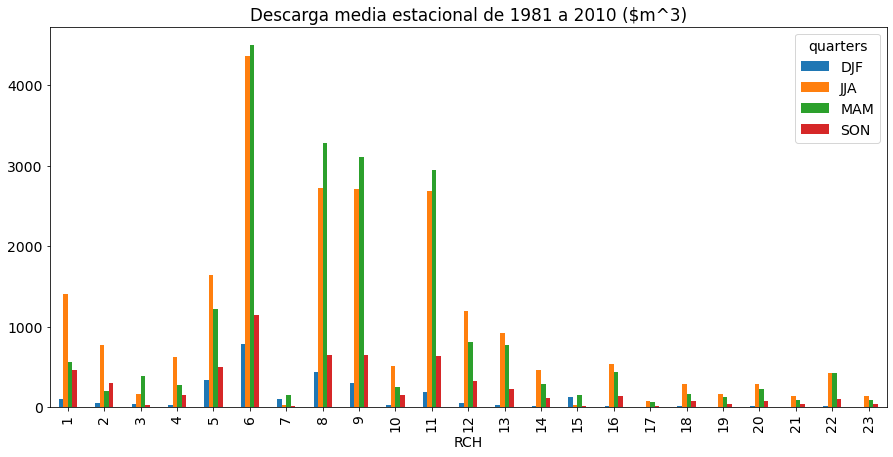

In [79]:
# Plot size to 15" x 7"
matplotlib.rc('figure', figsize = (15, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Display top and right frame lines
matplotlib.rc('axes.spines', top = True, right = True)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

pivoted.plot(kind='bar', title='Descarga media estacional de 1981 a 2010 ($m^3)')

## Uso de SQLite como base de datos de series temporales
SQLite admite cinco funciones de fecha y hora, a saber

- date(timestring, modificador, modificador, ...)
- time(timestring, modificador, modificador, ...)
- datetime(timestring, modificador, modificador, ...)
- julianday(timestring, modificador, modificador, ...)
- strftime(formato, cadena de tiempo, modificador, modificador, ...)

Las cinco funciones de fecha y hora toman una cadena de tiempo como argumento. La cadena de tiempo va seguida de cero o más modificadores. La función strftime() también toma una cadena de formato como primer argumento. Con estas funciones de fecha y hora, podemos guardar los datos de las series temporales en una base de datos SQLite para utilizarla como base de datos de series temporales.

En este cuaderno, crearemos una tabla para guardar los datos de la temperatura artificial en diferentes fechas y horas. Se puede suponer que se recogen de algún tipo de sensores de temperatura.

Este cuaderno presentará:

- Practicar las funciones de fecha y hora
- Crear una tabla de temperaturas y un índice
- Insertar datos en la tabla de temperaturas
- Consultar


In [80]:
from random import uniform, choice
import time
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline

## Cacharreemos con las funciones de fecha y hora
Puedes encontrar más ejemplos en https://www.sqlite.org/lang_datefunc.html o https://www.tutorialspoint.com/sqlite/sqlite_date_time.htm

- Calculemos la fecha actual.

In [81]:
%sql SELECT date('now');

 * sqlite:///data/demo.db3
Done.


date('now')
2022-06-24


- Calculemos el último día del mes actual.


In [85]:
%sql SELECT date('now','start of month','+1 month','-1 day');

 * sqlite:///data/demo.db3
Done.


"date('now','start of month','+1 month','-1 day')"
2022-06-30


- Calculemos la fecha del primer martes de octubre del año en curso.

In [86]:
%sql SELECT date('now','start of year','+9 months','weekday 2');

 * sqlite:///data/demo.db3
Done.


"date('now','start of year','+9 months','weekday 2')"
2022-10-04


## Crear una tabla de series temporales de temperatura
### Crear una tabla sólo con dos columnas, timestamp y Temperatura

In [101]:
%%sql sqlite://
DROP TABLE IF EXISTS Temperature;
CREATE TABLE Temperature (Timestamp DATETIME NOT NULL, Temperature NUMERIC NOT NULL)

Done.
Done.


[]

## Crear un índice
Para que la consulta sea eficiente, querremos indexar la columna timestamp.

In [102]:
%%sql sqlite://
CREATE UNIQUE INDEX idx_timestamp ON Temperature (Timestamp);

Done.


[]

## Insertar datos
Haz 500 filas de datos y rangos de temperatura entre 18 y 26.

In [103]:
def dt(days, hours):
    return timedelta(days=days, hours = hours)

N_rows = 500
now = datetime.now()

for i in range(N_rows):
    timestamp = now - dt(days=(N_rows - i), hours = 5)
    temperature = uniform(18, 26)
    %sql INSERT INTO Temperature VALUES (:timestamp, :temperature); 

 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 rows affected.
 * sqlite:///data/demo.db3
1 row

## Juguemos con la tabla de series temporales
### Consulta simple

In [104]:
%sql SELECT datetime(Timestamp) as Date, Temperature FROM Temperature LIMIT 5

 * sqlite:///data/demo.db3
Done.


Date,Temperature
2021-02-09 16:16:22,24.349827990988437
2021-02-10 16:16:22,21.051902929872412
2021-02-11 16:16:22,22.065132071951286
2021-02-12 16:16:22,22.574594531359807
2021-02-13 16:16:22,19.35437059914692


### Filtrar con una fecha

In [105]:
%%sql sqlite://
SELECT Timestamp as Date, Temperature
FROM Temperature
WHERE Date <= '2021-12-31 16:16:22'

Done.


Date,Temperature
2021-02-09 16:16:22.628071,24.349827990988437
2021-02-10 16:16:22.628071,21.051902929872412
2021-02-11 16:16:22.628071,22.065132071951286
2021-02-12 16:16:22.628071,22.574594531359807
2021-02-13 16:16:22.628071,19.35437059914692
2021-02-14 16:16:22.628071,23.327213332475175
2021-02-15 16:16:22.628071,20.43630950199
2021-02-16 16:16:22.628071,22.29568636870001
2021-02-17 16:16:22.628071,22.421995518825735
2021-02-18 16:16:22.628071,25.988354116254616


## Consulta de datos en un año específico
Usar CAST string to integer como strftime devuelve una cadena.

In [115]:
%%sql sqlite://
SELECT Timestamp, Temperature, CAST(strftime("%m",Timestamp) as INT) as MO
FROM Temperature
WHERE MO = 2

Done.


Timestamp,Temperature,MO
2021-02-09 16:16:22.628071,24.349827990988437,2
2021-02-10 16:16:22.628071,21.051902929872412,2
2021-02-11 16:16:22.628071,22.065132071951286,2
2021-02-12 16:16:22.628071,22.574594531359807,2
2021-02-13 16:16:22.628071,19.35437059914692,2
2021-02-14 16:16:22.628071,23.327213332475175,2
2021-02-15 16:16:22.628071,20.43630950199,2
2021-02-16 16:16:22.628071,22.29568636870001,2
2021-02-17 16:16:22.628071,22.421995518825735,2
2021-02-18 16:16:22.628071,25.988354116254616,2


## Agregado anual

In [116]:
%%sql sqlite://
SELECT strftime('%Y', Timestamp) as Year, 
       AVG(Temperature) AS MEAN_TMP,
       MAX(Temperature) AS MAX_TMP,
       MIN(Temperature) AS MIN_TMP
FROM Temperature
GROUP BY strftime('%Y', Timestamp)

Done.


Year,MEAN_TMP,MAX_TMP,MIN_TMP
2021,21.81973813502875,25.988354116254616,18.00283702973796
2022,22.34741789606761,25.989891641864162,18.04142901432742


In [117]:
%%sql sqlite://
SELECT strftime('%Y', Timestamp) as Year, 
       AVG(Temperature) AS MEAN_TMP,
       MAX(Temperature) AS MAX_TMP,
       MIN(Temperature) AS MIN_TMP
FROM Temperature
GROUP BY Year

Done.


Year,MEAN_TMP,MAX_TMP,MIN_TMP
2021,21.81973813502875,25.988354116254616,18.00283702973796
2022,22.34741789606761,25.989891641864162,18.04142901432742


## Visualización
Aquí convertimos los resultados de la consulta SQL en Pandas DataFrame.

In [118]:
timeSeries = %sql SELECT datetime(Timestamp) as date, Temperature FROM Temperature
df = timeSeries.DataFrame()
df.set_index("date", inplace = True) 
df.index = pd.to_datetime(df.index)
df.index

 * sqlite:///data/demo.db3
Done.


DatetimeIndex(['2021-02-09 16:16:22', '2021-02-10 16:16:22',
               '2021-02-11 16:16:22', '2021-02-12 16:16:22',
               '2021-02-13 16:16:22', '2021-02-14 16:16:22',
               '2021-02-15 16:16:22', '2021-02-16 16:16:22',
               '2021-02-17 16:16:22', '2021-02-18 16:16:22',
               ...
               '2022-06-14 16:16:22', '2022-06-15 16:16:22',
               '2022-06-16 16:16:22', '2022-06-17 16:16:22',
               '2022-06-18 16:16:22', '2022-06-19 16:16:22',
               '2022-06-20 16:16:22', '2022-06-21 16:16:22',
               '2022-06-22 16:16:22', '2022-06-23 16:16:22'],
              dtype='datetime64[ns]', name='date', length=500, freq=None)

<AxesSubplot:xlabel='date'>

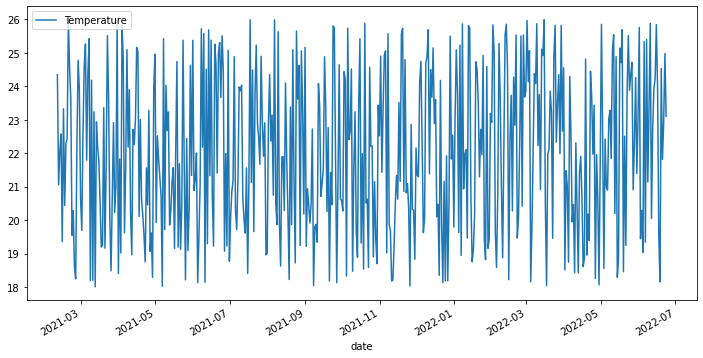

In [119]:
df.plot(figsize=(12, 6))